In [1]:
# !apt update && apt install -y python3-opencv
# !pip install -r requirements.txt

# Multimedia Information Retrieval

The main objective for this project is to develop an information retrieval system, using some concepts seen in Multimedia classes, such as a dictionary of visual words and local feature extraction. Given an image, we should return the most similar images from the dataset.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

# Dataset Preprocessing

The dataset we used (https://www.csc.kth.se/~heydarma/Datasets.html) has images from animals and a mask, representing the foreground of the images. Here, we are using this mask to delimit a blur, so the background will not affect so much the final result.

In [3]:
def preprocess(directory, filename):
    img = cv2.imread(f"{directory}/original/{filename}.jpg")
    seg = cv2.imread(f"{directory}/segment/{filename}.png")

    blurred = cv2.blur(img, (25, 25))
    out = np.where(seg == np.array([1, 1, 1]), img, blurred)

    out_dir = 'preprocessed'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    cv2.imwrite(f'{out_dir}/{filename}.jpg', out)

for animal in os.listdir('dataset'):
    for img in os.listdir(f'dataset/{animal}/original'):
        
        filename = img.split('.')
        if len(filename[0]) > 0:
            preprocess(f'dataset/{animal}', filename[0])

# Extract local features

Now we extract the local features of each image and create the Bag of Features.

In [10]:
def extract_descriptors(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # sift = cv2.SIFT_create()
    # keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(img, None)

    return keypoints, descriptors

def process(filename, draw_descriptors=False):
    img = cv2.imread(filename)
    keypoints, descriptors = extract_descriptors(img)

    if draw_descriptors:
        img_out = cv2.drawKeypoints(img, keypoints, img.copy())
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        plt.imshow(img_out)

    return descriptors

filenames = [f'preprocessed/{filename}' for filename in os.listdir('preprocessed')]

bag_features = []
for f_img in filenames:
    bag_features = bag_features + process(f_img).tolist()

# Create dictionary of descriptors

With the bag of features, we can cluster them into some groups. The centroids of each group will create the bag of visual words (BoVW).

In [5]:
def create_dict(bag, dict_size):
    bag = np.array(bag, dtype=np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(bag, dict_size, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # return a list of centroids
    return center

dict_size = 80

# bag of visual words
bovw = create_dict(bag_features, dict_size)

# Create histograms for dataset

With the BoVW created, we can create the histograms of visual words for each image, that will represent the image.

In [6]:
def euclidean_distance(pt1, pt2):
    return cv2.norm(np.float32(pt1), np.float32(pt2), cv2.NORM_L2)

def create_histogram(filename):
    des = process(filename)
    score = np.zeros(len(bovw)).astype(np.float32)

    for d in des:
        best = 0
        for j in range(len(bovw)):
            if euclidean_distance(d, bovw[j]) < euclidean_distance(d, bovw[best]):
                best = j
        score[best] += 1
    return score

histograms = [create_histogram(f) for f in filenames]

# Compare input image with dataset

Finally, we can create the histogram for another image, and compare it with the dataset created.

In [7]:
def compare_histograms(h1, h2):
    return euclidean_distance(h1, h2)
    # method = cv2.HISTCMP_CHISQR
    # return cv2.compareHist(h1, h2, method)

filename = "preprocessed/giraffe_1.jpg"

input_desc = process(filename)
input_hist = create_histogram(filename)

results = []
for i in range(len(histograms)):
    dist = compare_histograms(input_hist, histograms[i])
    results.append([filenames[i], dist])

results = np.array(results)
results = results[results[:, 1].astype(np.float64).argsort()]

# Output list of similar images

List of the 10 most similar images and plot of the 4 most similar images.

10 most similar images:
preprocessed/giraffe_1.jpg  -> Distance:  0.0
preprocessed/gorilla_4.jpg  -> Distance:  40.08740450565489
preprocessed/wolf_3.jpg  -> Distance:  41.79712908801273
preprocessed/giraffe_6.jpg  -> Distance:  43.94314508543966
preprocessed/wolf_2.jpg  -> Distance:  45.51922670696417
preprocessed/kangaroo_2.jpg  -> Distance:  45.617978911828175
preprocessed/cow_9.jpg  -> Distance:  47.01063709417264
preprocessed/penguim_1.jpg  -> Distance:  47.11687595755899
preprocessed/cow_5.jpg  -> Distance:  47.41307836451879
preprocessed/wolf_9.jpg  -> Distance:  47.885279575251516


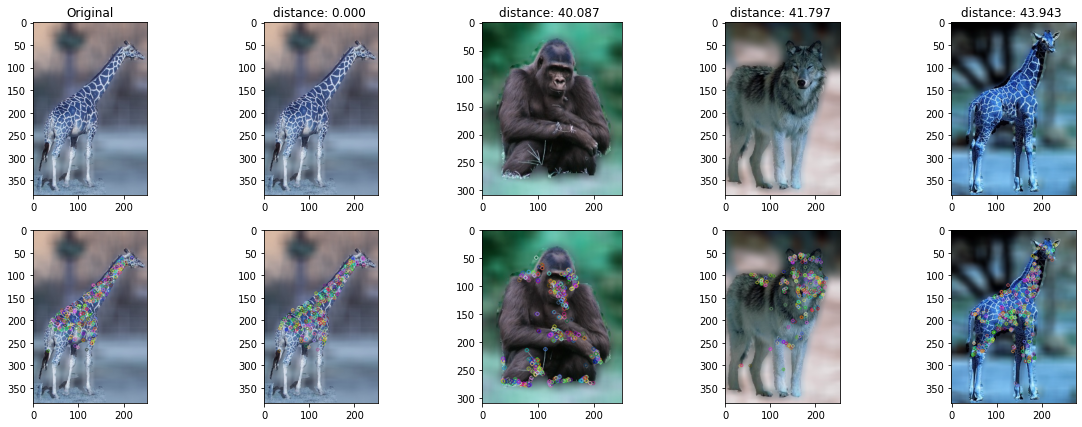

In [14]:
print('10 most similar images:')
for i in range(10):
    print(results[i, 0], ' -> Distance: ', results[i, 1])

plt.figure(figsize=(20, 7))

plt.subplot(251)
plt.imshow(cv2.imread(filename))
plt.title('Original')
for i in range(4):
    plt.subplot(2, 5, i + 2)
    plt.imshow(cv2.imread(results[i][0]))
    plt.title('distance: %.3f ' % (float(results[i][1])))

plt.subplot(256)
img = cv2.imread(filename)
keypoints, descriptors = extract_descriptors(img)
plt.imshow(cv2.drawKeypoints(img, keypoints, img.copy()))
for i in range(4):
    plt.subplot(2, 5, i + 7)

    img = cv2.imread(results[i][0])
    keypoints, descriptors = extract_descriptors(img)
    plt.imshow(cv2.drawKeypoints(img, keypoints, img.copy()))

# Efficiency test

Now we utilise the F1 score to classify the accuracy of our program. It conveys a balance between the precision and the recall of the result.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c49759d8-944a-4cb2-ae9b-3a17004d3b2a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>